# Capstone_Project: After-school program

# Introduction

## Introduction to the problem and background



Let's say one of my friends (living in Lansing Capital Area, Michigan State) plans to initialize an after-school program for elementary school students and middle-school students. He came to me and asked me for the suggestion on the location of the after-school program.
In order to provide sound advice for him, we should consider the following factors:
 
- number of schools (public and private) in the neighbourhood.
- population in the neighbourhood.
- number of venues (stores and restaurants) in the neighbourhood. 
- distance from the downtown

Definitely, the travel cost from the schools to the after-school spot is positively correlated to the distance between them. Moreover, there is a high probability that the more schools around the after-school spot, the more students will enroll the after school program. But one should also check if there already exist other after-school programs in the neighborhood. Besides, the number of stores and restraunts also has a positve impact on the enrollment.


## Introduction to the data 

To this end, we should collect the data of public and private schools, as well as the venues in the neighbourhoods. 
Here are the sources of each type of data:

- US zipcode can be found either from https://simplemaps.com/data/us-zips (recommended) or http://federalgovernmentzipcodes.us
  The population correspondign to each zipcode is also provided in the data.

- Geocodes for public schools are availe from https://nces.ed.gov/programs/edge/Geographic/SchoolLocations 

The information of Latitude and Longitude is provided in all the files.

## Introduction to the methodology
 
The python packages that we are going to use include (but not limited to):

- requests
- folium
- Nominatim
- pandas
- numpy

as well as foursquare API.

The procedure of preparing the data can be as follows:

- download/read all the datasets from websites. 
- filter out all the schools in the area of interest.
- use Foursquare API to get all the venues (restraunts) in the area. 
- visualize the location of the schools and venues with the folium.Map()
- use the groupby method to find out the number of schools and venues in each neighbourhood, which is defined based on the zipcode.
- find out the population of each neighbourhood.
- order the neighbourhoods based on the number of schools/venues and populations and use this ratio as a guideline 
 

#  Data prepation and analysis

##  Import packages

In [326]:
import requests
from pandas.io.json import json_normalize
import pandas as pd 
import numpy as np
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim 


## Preparation of the data

download zipcode file from the website https://simplemaps.com/data/us-zips. 
Here we have already downloaded it into the local directory.

In [547]:
path='uszipsv1.4.csv' 

US_zipcode=pd.read_csv(path) 

US_zipcode.head()

zip      lat      lng        city state_id   state_name   zcta  \
0  501  40.8133 -73.0476  Holtsville       NY     New York  False   
1  544  40.8133 -73.0476  Holtsville       NY     New York  False   
2  601  18.1800 -66.7522    Adjuntas       PR  Puerto Rico   True   
3  602  18.3607 -67.1752      Aguada       PR  Puerto Rico   True   
4  603  18.4544 -67.1220   Aguadilla       PR  Puerto Rico   True   

   parent_zcta  population  county_fips county_name  \
0      11742.0         NaN          NaN         NaN   
1      11742.0         NaN          NaN         NaN   
2          NaN     18570.0      72001.0    Adjuntas   
3          NaN     41520.0      72003.0      Aguada   
4          NaN     54689.0      72005.0   Aguadilla   

             all_county_weights  imprecise  military  
0                           NaN       True     False  
1                           NaN       True     False  
2  {'72001':99.43,'72141':0.57}      False     False  
3                 {'72003':100}      False     False  
4                 {'72005':100}      False     False

We are only interested in the data in the Great Lansing Area. Therefore, we define a filter on both State and City names and pick those data out as a new dataframe.

In [548]:
c0 =  US_zipcode['state_name'] =='Michigan'
c1 =  US_zipcode['city'] =='Lansing' 
c2 =  US_zipcode['city'] =='Okemos' 
c3 =  US_zipcode['city'] =='Haslett' 
c4 =  US_zipcode['city'] =='Mason' 
c5 =  US_zipcode['city'] =='Holt'
c6 =  US_zipcode['city'] =='East Lansing'

In [549]:
Great_Lansing = US_zipcode[(c0) & ((c1) | (c2) | (c3) | (c4) | (c5) | (c6))]
Great_Lansing.head()

zip      lat      lng          city state_id state_name   zcta  \
20914  48805  42.7082 -84.4144        Okemos       MI   Michigan  False   
20930  48823  42.7620 -84.4539  East Lansing       MI   Michigan   True   
20931  48824  42.7229 -84.4751  East Lansing       MI   Michigan  False   
20932  48825  42.7270 -84.4809  East Lansing       MI   Michigan   True   
20933  48826  42.7360 -84.4843  East Lansing       MI   Michigan  False   

       parent_zcta  population  county_fips county_name  \
20914      48864.0         NaN          NaN         NaN   
20930          NaN     51302.0      26065.0      Ingham   
20931      48825.0         NaN          NaN         NaN   
20932          NaN     12596.0      26065.0      Ingham   
20933      48823.0         NaN          NaN         NaN   

                all_county_weights  imprecise  military  
20914                          NaN       True     False  
20930  {'26037':14.5,'26065':85.5}      False     False  
20931                          NaN      False     False  
20932                {'26065':100}      False     False  
20933                          NaN       True     False

Taking out the information that we need

In [550]:
columns = ['zip','lat','lng','city','population']
GL_population = Great_Lansing[columns]

In [551]:
GL_population.rename(columns={'zip':'Zipcode','city':'City','lat':'Lat','lng':'Lon','population':'Population'},inplace=True) 
GL_population.head()

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


Zipcode      Lat      Lon          City  Population
20914    48805  42.7082 -84.4144        Okemos         NaN
20930    48823  42.7620 -84.4539  East Lansing     51302.0
20931    48824  42.7229 -84.4751  East Lansing         NaN
20932    48825  42.7270 -84.4809  East Lansing     12596.0
20933    48826  42.7360 -84.4843  East Lansing         NaN

In [552]:
print("There are {} neighbourhoods in the Great Lansing Area with {} different Latitudes.".format(len(GL_population['Zipcode']),
                                                                                                  len(GL_population['Lat'].unique())))

There are 31 neighbourhoods in the Great Lansing Area with 20 different Latitudes.


Now let's prepare the data for schools:

- public schools
- private schools

We have already downloaded them into the local directory.

### public schools

In [506]:
public_path='EDGE_GEOCODE_PUBLICSCH_1617/EDGE_GEOCODE_PUBLICSCH_1617.xlsx'
Public_Schools = pd.read_excel(public_path)

Again, we define filters to pick out the data that we are interested.

In [507]:
c0 = Public_Schools['STATE'] == 'MI'
c1 = Public_Schools['CITY'] =='LANSING'
c2 = Public_Schools['CITY'] =='OKEMOS'
c3 = Public_Schools['CITY'] =='HASLETT'
c4 = Public_Schools['CITY'] =='EAST LANSING'
c5 = Public_Schools['CITY'] =='MASON'
c6 = Public_Schools['CITY'] =='HOLT'

GL_pub_schools = Public_Schools[(c0) & ((c1) | (c2) | (c3) | (c4) | (c5) | (c6))]
GL_pub_schools.head()

NCESSCH                              NAME  OPSTFIPS  \
43329  260007900543                      Cole Academy        26   
43330  260008000544  El-Hajj Malik El-Shabazz Academy        26   
43331  260008200546   Mid-Michigan Leadership Academy        26   
43419  260020301114    Windemere Park Charter Academy        26   
43565  260095908074           Lansing Charter Academy        26   

                         STREET     CITY STATE    ZIP STFIP   CNTY  \
43329  1915 WEST MOUNT HOPE AVE  LANSING    MI  48910    26  26065   
43330      1028 WEST BARNES AVE  LANSING    MI  48910    26  26065   
43331         730 WEST MAPLE ST  LANSING    MI  48906    26  26065   
43419      3100 WEST SAGINAW ST  LANSING    MI  48917    26  26065   
43565           3300 EXPRESS CT  LANSING    MI  48910    26  26065   

              NMCNTY   ...                       NMCBSA  CBSATYPE  CSA  \
43329  Ingham County   ...     Lansing-East Lansing, MI         1  330   
43330  Ingham County   ...     Lansing-East Lansing, MI         1  330   
43331  Ingham County   ...     Lansing-East Lansing, MI         1  330   
43419  Ingham County   ...     Lansing-East Lansing, MI         1  330   
43565  Ingham County   ...     Lansing-East Lansing, MI         1  330   

                                 NMCSA NECTA  NMNECTA    CD   SLDL   SLDU  \
43329  Lansing-East Lansing-Owosso, MI     N        N  2608  26068  26023   
43330  Lansing-East Lansing-Owosso, MI     N        N  2608  26068  26023   
43331  Lansing-East Lansing-Owosso, MI     N        N  2608  26068  26023   
43419  Lansing-East Lansing-Owosso, MI     N        N  2608  26068  26023   
43565  Lansing-East Lansing-Owosso, MI     N        N  2608  26068  26023   

      SURVYEAR  
43329     2016  
43330     2016  
43331     2016  
43419     2016  
43565     2016  

[5 rows x 24 columns]

In [508]:
GL_pub_schools.columns

Index(['NCESSCH', 'NAME', 'OPSTFIPS', 'STREET', 'CITY', 'STATE', 'ZIP',
       'STFIP', 'CNTY', 'NMCNTY', 'LOCALE', 'LAT', 'LON', 'CBSA', 'NMCBSA',
       'CBSATYPE', 'CSA', 'NMCSA', 'NECTA', 'NMNECTA', 'CD', 'SLDL', 'SLDU',
       'SURVYEAR'],
      dtype='object')

In [509]:
columns = ['NAME','CITY','ZIP','LAT','LON']
GL_pubs = GL_pub_schools[columns]
GL_pubs.rename(columns={'NAME':'Name','CITY':'City','ZIP':'Zipcode','LAT':'Lat','LON':'Lon'},inplace=True)
GL_pubs.head()

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


Name     City  Zipcode        Lat  \
43329                      Cole Academy  LANSING    48910  42.711623   
43330  El-Hajj Malik El-Shabazz Academy  LANSING    48910  42.715258   
43331   Mid-Michigan Leadership Academy  LANSING    48906  42.746410   
43419    Windemere Park Charter Academy  LANSING    48917  42.741789   
43565           Lansing Charter Academy  LANSING    48910  42.699119   

             Lon  
43329 -84.578810  
43330 -84.566713  
43331 -84.563371  
43419 -84.591616  
43565 -84.575243

In [510]:
print("There are {} public schools in the Great Lansing Area with {} different neighbourhoods.".format(len(GL_pubs['Name']),
                                                                                                  len(GL_pubs['Zipcode'].unique())))

There are 69 public schools in the Great Lansing Area with 11 different neighbourhoods.


### Private Schools

In [511]:
private_schools = pd.read_excel('EDGE_GEOCODE_PRIVATESCH_15_16/EDGE_GEOCODE_PRIVATESCH_1516.xlsx')
private_schools.head()

PPIN                                         PINST  \
0  A0100060                          CAMELLIA BAPTIST WEM   
1  A0900032               FIRST PRESBYTERIAN KINDERGARTEN   
2  00002722                               AUTAUGA ACADEMY   
3  K9300030                    FIRST BAPTIST KINDERGARTEN   
4  00002176  MARIETTA JOHNSON SCHOOL OF ORGANIC EDUCATION   

                PL_ADD      PL_CIT PL_STABB PL_ZIP PL_ZIP4  STFIP15  CNTY15  \
0    201 WOODVALE ROAD  PRATTVILLE       AL  36067    2713        1    1001   
1    211 S CHESTNUT ST  PRATTVILLE       AL  36067    3023        1    1001   
2        497 GOLSON RD  PRATTVILLE       AL  36067    9702        1    1001   
3  138 S WASHINGTON ST  PRATTVILLE       AL  36067     NaN        1    1001   
4        8 MARIETTA DR    FAIRHOPE       AL  36532    1653        1    1003   

         NMCNTY15  ...    CBSA15                   NMCBSA15  CBSATYPE15 CSA15  \
0  Autauga County  ...     33860             Montgomery, AL           1     N   
1  Autauga County  ...     33860             Montgomery, AL           1     N   
2  Autauga County  ...     33860             Montgomery, AL           1     N   
3  Autauga County  ...     33860             Montgomery, AL           1     N   
4  Baldwin County  ...     19300  Daphne-Fairhope-Foley, AL           1   380   

                      NMCSA15 NECTA15 NMNECTA15 CD15 SLDL15 SLDU15  
0                           N       N         N  102     88     30  
1                           N       N         N  102     88     30  
2                           N       N         N  102     42     30  
3                           N       N         N  102     88     30  
4  Mobile-Daphne-Fairhope, AL       N         N  101     94     32  

[5 rows x 23 columns]

In [512]:
c0 = private_schools['PL_STABB'] =='MI'
c1 = private_schools['PL_CIT'] =='LANSING'
c2 = private_schools['PL_CIT'] =='OKEMOS'
c3 = private_schools['PL_CIT'] =='HASLETT'
c4 = private_schools['PL_CIT'] =='EAST LANSING'
c5 = private_schools['PL_CIT'] =='HOLT'
c6 = private_schools['PL_CIT'] =='MASON'
 
GL_private_schools = private_schools[(c0) & ((c1) | (c2) | (c3) | (c4) | (c5) | (c6))]
GL_private_schools.head()

PPIN                             PINST                  PL_ADD  \
10007  A1502011  GREATER LANSING ADVENTIST SCHOOL       5330 W ST JOE HWY   
10009  00642751        OUR SAVIOR LUTHERAN SCHOOL       7910 E ST JOE HWY   
10013  00640197       ST GERARD ELEMENTARY SCHOOL       4433 W WILLOW HWY   
10067  01610864       CAPITOL CITY BAPTIST SCHOOL      5100 WILLOUGHBY RD   
10068  02037083        MONTESSORI CHILDRENS HOUSE  2100 W SAINT JOSEPH ST   

        PL_CIT PL_STABB PL_ZIP PL_ZIP4  STFIP15  CNTY15       NMCNTY15  ...    \
10007  LANSING       MI  48917    4060       26   26045   Eaton County  ...     
10009  LANSING       MI  48917    8871       26   26045   Eaton County  ...     
10013  LANSING       MI  48917     NaN       26   26045   Eaton County  ...     
10067     HOLT       MI  48842    1098       26   26065  Ingham County  ...     
10068  LANSING       MI  48915    1175       26   26065  Ingham County  ...     

       CBSA15                  NMCBSA15  CBSATYPE15 CSA15  \
10007   29620  Lansing-East Lansing, MI           1   330   
10009   29620  Lansing-East Lansing, MI           1   330   
10013   29620  Lansing-East Lansing, MI           1   330   
10067   29620  Lansing-East Lansing, MI           1   330   
10068   29620  Lansing-East Lansing, MI           1   330   

                               NMCSA15 NECTA15 NMNECTA15  CD15 SLDL15 SLDU15  
10007  Lansing-East Lansing-Owosso, MI       N         N  2607     71     24  
10009  Lansing-East Lansing-Owosso, MI       N         N  2607     71     24  
10013  Lansing-East Lansing-Owosso, MI       N         N  2607     71     24  
10067  Lansing-East Lansing-Owosso, MI       N         N  2608     67     23  
10068  Lansing-East Lansing-Owosso, MI       N         N  2608     68     23  

[5 rows x 23 columns]

In [513]:
#Private_Schools_MI_GL.rename(columns={'PL_ZIP':'ZIP','PL_CIT':'CITY'},inplace=True)
GL_private_schools.columns

Index(['PPIN', 'PINST', 'PL_ADD', 'PL_CIT', 'PL_STABB', 'PL_ZIP', 'PL_ZIP4',
       'STFIP15', 'CNTY15', 'NMCNTY15', 'LOCALE15', 'LAT1516', 'LON1516',
       'CBSA15', 'NMCBSA15', 'CBSATYPE15', 'CSA15', 'NMCSA15', 'NECTA15',
       'NMNECTA15', 'CD15', 'SLDL15', 'SLDU15'],
      dtype='object')

In [514]:
columns = ['PINST','PL_CIT','PL_ZIP','LAT1516','LON1516']
GL_privates = GL_private_schools[columns]
GL_privates.rename(columns={'PINST':'Name','PL_CIT':'City','PL_ZIP':'Zipcode','LAT1516':'Lat','LON1516':'Lon'},inplace=True)
GL_privates.head()

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


Name     City Zipcode        Lat        Lon
10007  GREATER LANSING ADVENTIST SCHOOL  LANSING   48917  42.726619 -84.624478
10009        OUR SAVIOR LUTHERAN SCHOOL  LANSING   48917  42.725150 -84.684151
10013       ST GERARD ELEMENTARY SCHOOL  LANSING   48917  42.747481 -84.611369
10067       CAPITOL CITY BAPTIST SCHOOL     HOLT   48842  42.653130 -84.550171
10068        MONTESSORI CHILDRENS HOUSE  LANSING   48915  42.727000 -84.580061

In [515]:
print("There are {} private schools in the Great Lansing Area with {} different neighbourhoods.".format(len(GL_privates['Name']),
                                                                                                  len(GL_privates['Zipcode'].unique())))

There are 15 private schools in the Great Lansing Area with 7 different neighbourhoods.


## A short summary

We have prepared three datasets for use
- **GL_population** for populations
- **GL_pubs**  for public schools
- **GL_privates** for private schools 

## Foursquare API

Next, we use the foursquare API to get venues for the area.

In [516]:
CLIENT_ID = 'L0RMBCMNYHTS4DGW4DE2G0WWVXX5SNG1U4T1R4BTXG0Z0WJ5OKEMOS' # your Foursquare ID
CLIENT_SECRET = '3NTSNQHDWPVKUDFHTLAA4FERGL0CBNOHCMIWEYTWFZG5UJFQOKEMOS' # your Foursquare Secret
VERSION = '20180605'
LIMIT = 100
radius = 5000

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: L0RMBCMNYHTS4DGW4DE2G0WWVXX5SNG1U4T1R4BTXG0Z0WJ5
CLIENT_SECRET:3NTSNQHDWPVKUDFHTLAA4FERGL0CBNOHCMIWEYTWFZG5UJFQ


In [517]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [518]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    count_name = 0
    for name, lat, lng in zip(names, latitudes, longitudes):
        count_name += 1
        print(count_name,'zipcode/neighbourhood:', name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [519]:
df = GL_population
Great_Lansing_venues = getNearbyVenues(names=df['Zipcode'],
                                   latitudes=df['Lat'],
                                   longitudes=df['Lon']
                                  )

1 zipcode/neighbourhood: 48805
2 zipcode/neighbourhood: 48823
3 zipcode/neighbourhood: 48824
4 zipcode/neighbourhood: 48825
5 zipcode/neighbourhood: 48826
6 zipcode/neighbourhood: 48840
7 zipcode/neighbourhood: 48842
8 zipcode/neighbourhood: 48854
9 zipcode/neighbourhood: 48864
10 zipcode/neighbourhood: 48901
11 zipcode/neighbourhood: 48906
12 zipcode/neighbourhood: 48908
13 zipcode/neighbourhood: 48909
14 zipcode/neighbourhood: 48910
15 zipcode/neighbourhood: 48911
16 zipcode/neighbourhood: 48912
17 zipcode/neighbourhood: 48913
18 zipcode/neighbourhood: 48915
19 zipcode/neighbourhood: 48916
20 zipcode/neighbourhood: 48917
21 zipcode/neighbourhood: 48918
22 zipcode/neighbourhood: 48919
23 zipcode/neighbourhood: 48922
24 zipcode/neighbourhood: 48924
25 zipcode/neighbourhood: 48929
26 zipcode/neighbourhood: 48930
27 zipcode/neighbourhood: 48933
28 zipcode/neighbourhood: 48937
29 zipcode/neighbourhood: 48951
30 zipcode/neighbourhood: 48956
31 zipcode/neighbourhood: 48980


In [520]:
print(Great_Lansing_venues.shape)

Great_Lansing_venues.head(10)

(255, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0         48805                42.7082                -84.4144   
1         48805                42.7082                -84.4144   
2         48805                42.7082                -84.4144   
3         48805                42.7082                -84.4144   
4         48823                42.7620                -84.4539   
5         48824                42.7229                -84.4751   
6         48824                42.7229                -84.4751   
7         48824                42.7229                -84.4751   
8         48824                42.7229                -84.4751   
9         48824                42.7229                -84.4751   

                                Venue  Venue Latitude  Venue Longitude  \
0           Tacoma Hills Natural Area       42.707812       -84.414238   
1            XFINITY Store by Comcast       42.705680       -84.416729   
2           Golden Eagle Nature Trail       42.710777       -84.410447   
3  Platinum Paint Coatings LLC Okemos       42.706187       -84.419868   
4              Walnut Hills Golf Club       42.759651       -84.454663   
5            MSU Horticulture Gardens       42.721251       -84.473551   
6                     MSU Dairy Store       42.724393       -84.478446   
7  Wharton Center for Performing Arts       42.724205       -84.471024   
8                  Abrams Planetarium       42.725554       -84.476291   
9      Michigan 4-H Children's Garden       42.720839       -84.472827   

     Venue Category  
0             Trail  
1  Business Service  
2             Trail  
3      Home Service  
4       Golf Course  
5            Garden  
6    Ice Cream Shop  
7           Theater  
8       Planetarium  
9            Garden

In [521]:
columns=['Neighborhood','Venue','Venue Latitude','Venue Longitude','Venue Category']
GL_venues_short = Great_Lansing_venues[columns]

In [522]:
GL_venues_short.head()

Neighborhood                               Venue  Venue Latitude  \
0         48805           Tacoma Hills Natural Area       42.707812   
1         48805            XFINITY Store by Comcast       42.705680   
2         48805           Golden Eagle Nature Trail       42.710777   
3         48805  Platinum Paint Coatings LLC Okemos       42.706187   
4         48823              Walnut Hills Golf Club       42.759651   

   Venue Longitude    Venue Category  
0       -84.414238             Trail  
1       -84.416729  Business Service  
2       -84.410447             Trail  
3       -84.419868      Home Service  
4       -84.454663       Golf Course

In [523]:
GL_venues=GL_venues_short.rename(columns={'Neighborhood':'Zipcode'})

In [524]:
GL_venues.head()

Zipcode                               Venue  Venue Latitude  \
0    48805           Tacoma Hills Natural Area       42.707812   
1    48805            XFINITY Store by Comcast       42.705680   
2    48805           Golden Eagle Nature Trail       42.710777   
3    48805  Platinum Paint Coatings LLC Okemos       42.706187   
4    48823              Walnut Hills Golf Club       42.759651   

   Venue Longitude    Venue Category  
0       -84.414238             Trail  
1       -84.416729  Business Service  
2       -84.410447             Trail  
3       -84.419868      Home Service  
4       -84.454663       Golf Course

# Visualization of the data

In [525]:
def get_latlon(address):
    geolocator = Nominatim()
    location   = geolocator.geocode(address)
    latitude   = location.latitude
    longitude  = location.longitude
    return latitude, longitude

In [526]:
latitude, longitude = get_latlon("Lansing, MI")
latitude, longitude

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


(42.7404617, -84.5468496)

In [583]:

map_Great_Lansing = folium.Map(location=[latitude, longitude], zoom_start=12)

# population
for lat, lng, zipcode, population in zip(GL_population['Lat'], GL_population['Lon'], 
                                         GL_population['Zipcode'], GL_population['Population']): 
    labels = 'Zipcode:{}, Population: {}'.format(zipcode,population)
    label = folium.Popup(labels,parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5, 
        color='blue',
        popup=label,
        fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Great_Lansing)  
    
map_Great_Lansing

# add markers to map
# public schools
for lat, lng, name in zip(GL_pubs['Lat'], GL_pubs['Lon'], GL_pubs['Name']): 
    labels = '{}'.format(name)
    label = folium.Popup(labels, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5, 
        color='green',
        popup=label,
        fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Great_Lansing)  
    # private schools
for lat, lng, name in zip(GL_privates['Lat'], GL_privates['Lon'], GL_privates['Name']): 
    labels = '{}'.format(name)
    label = folium.Popup(labels, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5, 
        color='yellow',
        popup=label,
        fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Great_Lansing)  

    #Neighborhood Latitude	Neighborhood Longitude	Venue	Venue Latitude	Venue Longitude	Venue Category
for lat, lng, name in zip(GL_venues['Venue Latitude'], 
                          GL_venues['Venue Longitude'], 
                          GL_venues['Venue']): 
    labels = '{}'.format(name)
    label = folium.Popup(labels, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5, 
        color='red',
        popup=label,
        fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Great_Lansing) 
    
     
    
map_Great_Lansing

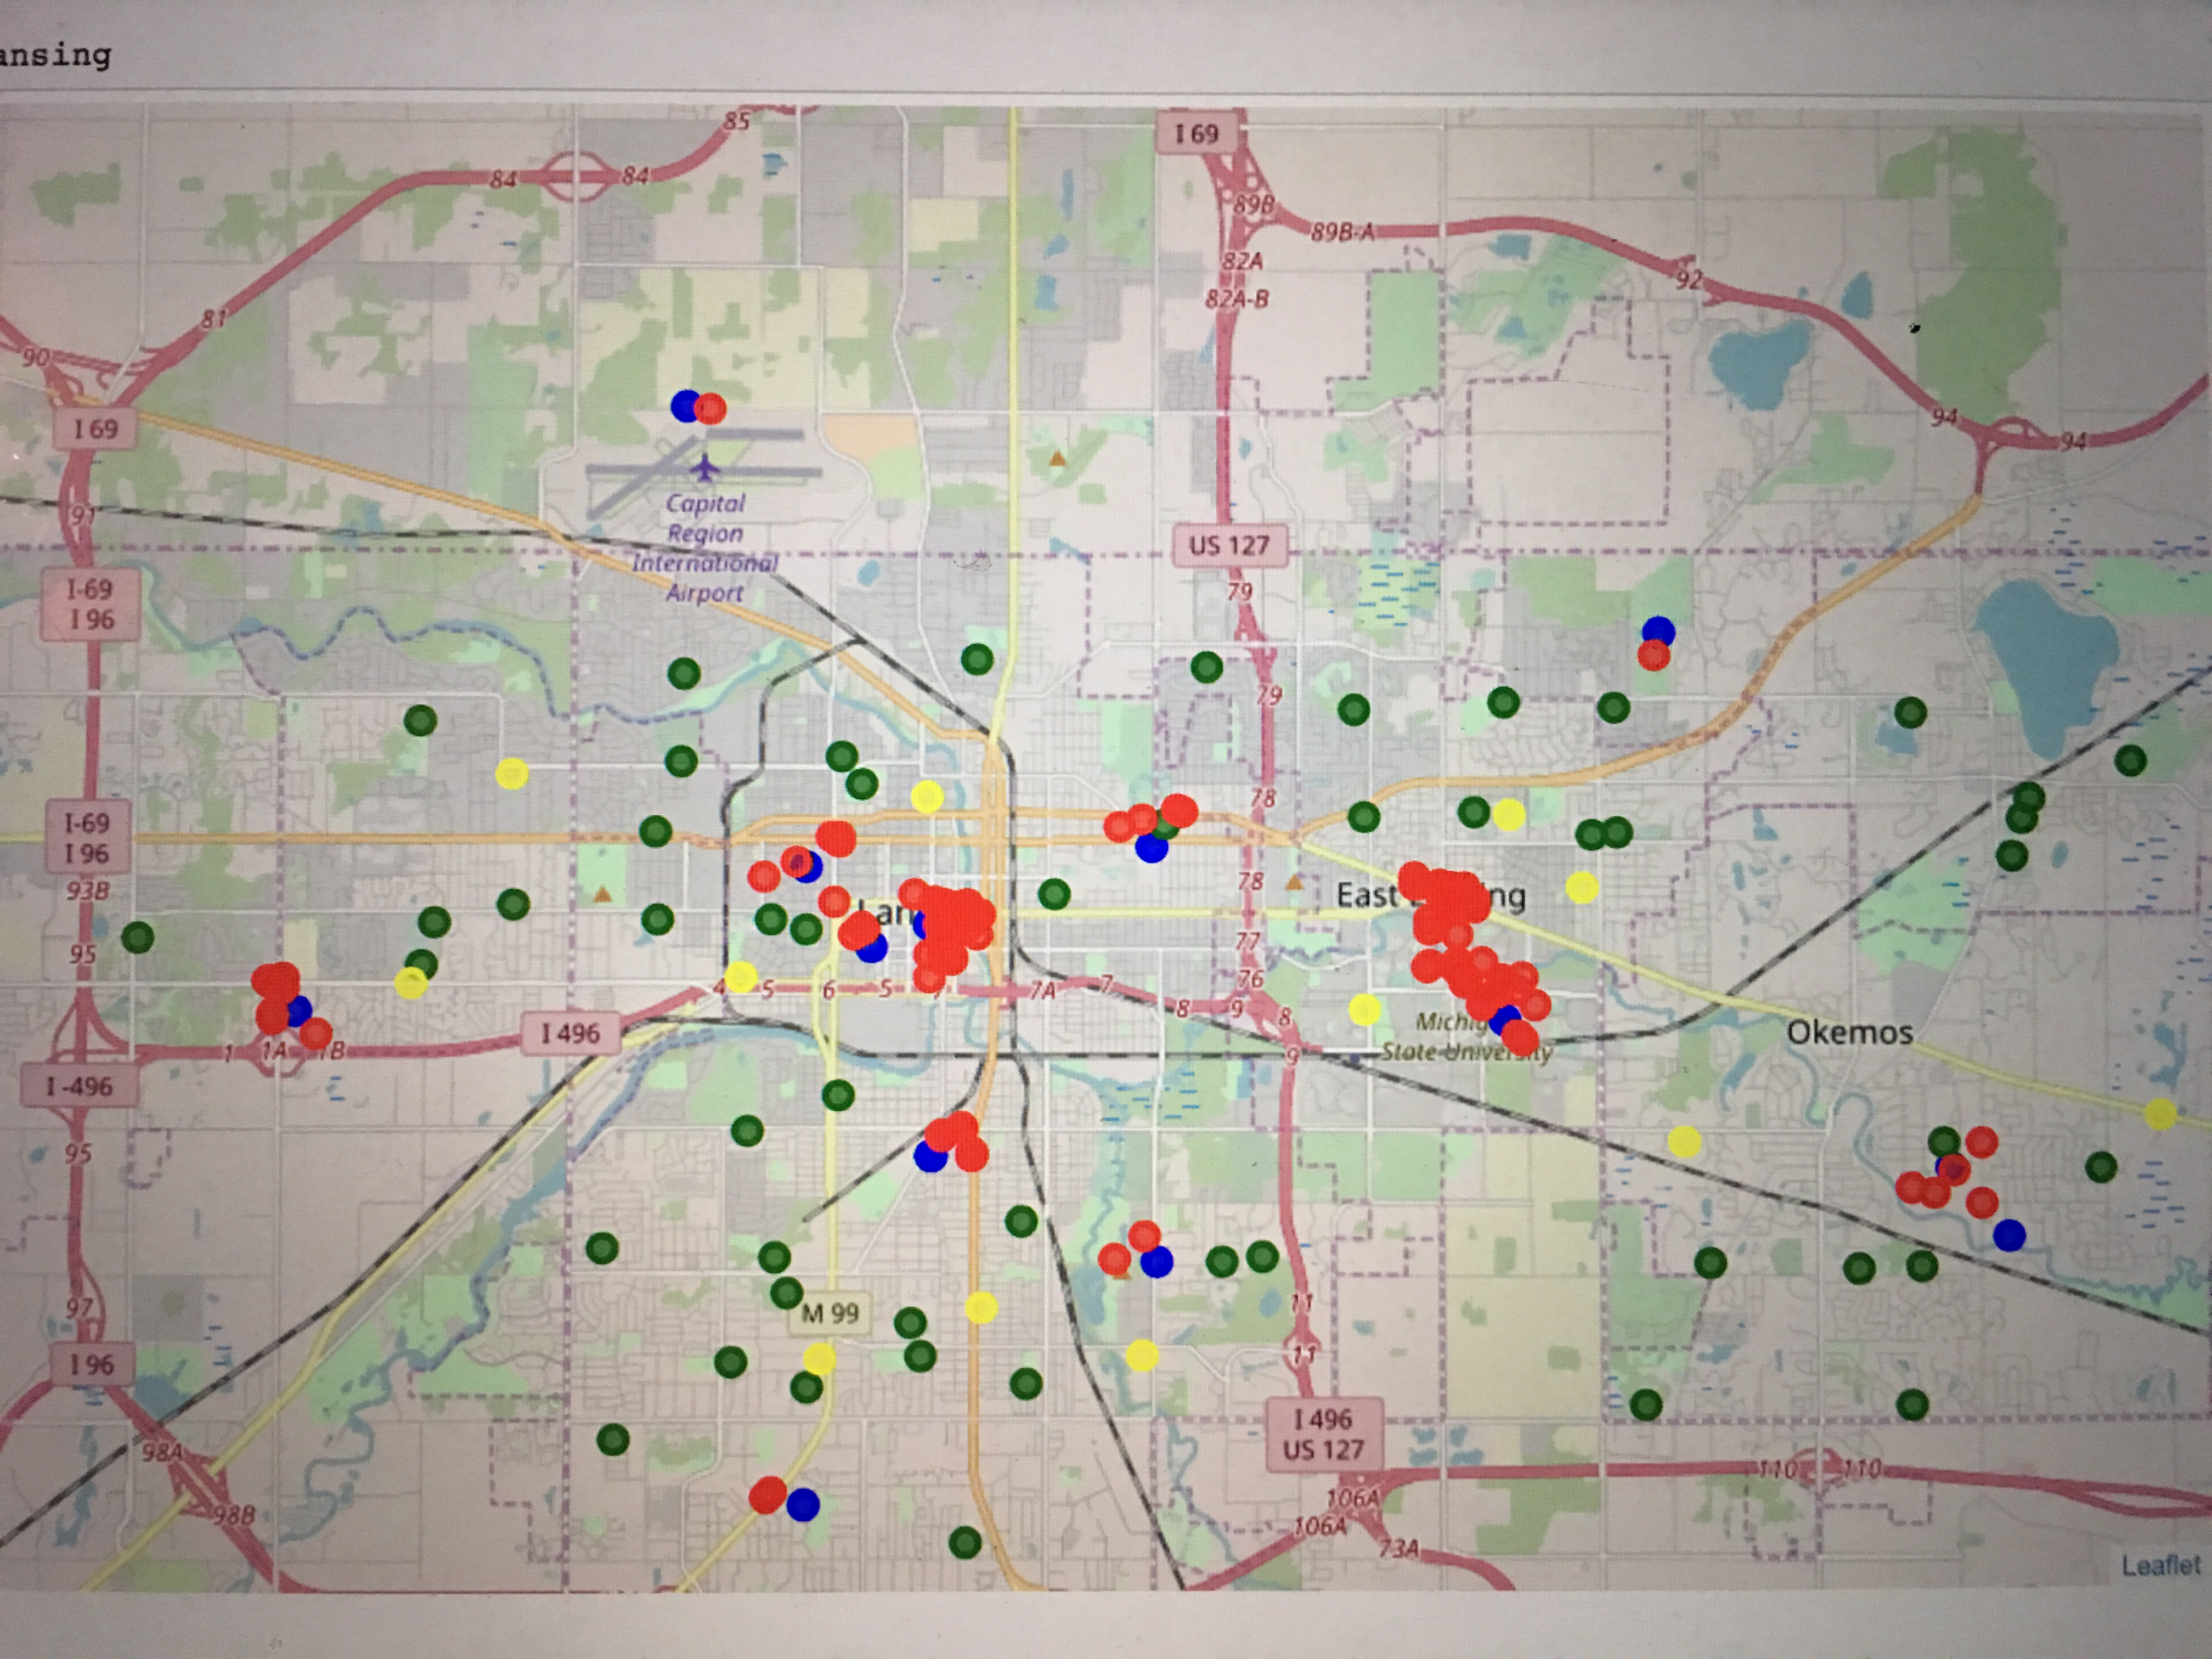

In [585]:
from IPython.display import Image
Image('map1.JPG')

## Fig1: distribution of public schools (green), private schools (yellow), venues (red) and neighbourhoods (blue) in Great Lansing Area.

In [554]:
print(GL_pubs.shape, GL_privates.shape)

(69, 5) (15, 5)


In [555]:
GL_all_schools = pd.concat([GL_pubs,GL_privates],axis=0,join='outer')
GL_all_schools.shape

(84, 5)

In [556]:
GL_all_schools_summary=pd.DataFrame(GL_all_schools.groupby('Zipcode').count().sort_values(by='Name',ascending=False))
GL_all_schools_summary.rename(columns={'Name':'School Name'},inplace=True)
GL_all_schools_summary

School Name  City  Lat  Lon
Zipcode                             
48910             12    12   12   12
48842             10    10   10   10
48854              8     8    8    8
48917              8     8    8    8
48823              7     7    7    7
48864              7     7    7    7
48840              5     5    5    5
48910              3     3    3    3
48823              3     3    3    3
48915              3     3    3    3
48912              3     3    3    3
48911              3     3    3    3
48906              3     3    3    3
48917              3     3    3    3
48842              2     2    2    2
48864              2     2    2    2
48906              1     1    1    1
48915              1     1    1    1

In [557]:
GL_venues.head()

Zipcode                               Venue  Venue Latitude  \
0    48805           Tacoma Hills Natural Area       42.707812   
1    48805            XFINITY Store by Comcast       42.705680   
2    48805           Golden Eagle Nature Trail       42.710777   
3    48805  Platinum Paint Coatings LLC Okemos       42.706187   
4    48823              Walnut Hills Golf Club       42.759651   

   Venue Longitude    Venue Category  
0       -84.414238             Trail  
1       -84.416729  Business Service  
2       -84.410447             Trail  
3       -84.419868      Home Service  
4       -84.454663       Golf Course

In [558]:
GL_venues_summary = pd.DataFrame(GL_venues.groupby('Zipcode').count().sort_values(by='Venue',ascending=False))
GL_venues_summary

Venue  Venue Latitude  Venue Longitude  Venue Category
Zipcode                                                        
48933       47              47               47              47
48826       46              46               46              46
48909       45              45               45              45
48825       14              14               14              14
48854       12              12               12              12
48917        9               9                9               9
48824        8               8                8               8
48915        6               6                6               6
48924        4               4                4               4
48919        4               4                4               4
48922        4               4                4               4
48805        4               4                4               4
48929        4               4                4               4
48930        4               4                4               4
48937        4               4                4               4
48956        4               4                4               4
48916        4               4                4               4
48912        4               4                4               4
48913        4               4                4               4
48908        4               4                4               4
48901        4               4                4               4
48980        4               4                4               4
48951        3               3                3               3
48911        2               2                2               2
48910        2               2                2               2
48823        1               1                1               1
48906        1               1                1               1
48864        1               1                1               1
48842        1               1                1               1
48840        1               1                1               1

In [559]:
GL_population2 = GL_population.set_index('Zipcode')

In [560]:
GL_population2

Lat      Lon          City  Population
Zipcode                                            
48805    42.7082 -84.4144        Okemos         NaN
48823    42.7620 -84.4539  East Lansing     51302.0
48824    42.7229 -84.4751  East Lansing         NaN
48825    42.7270 -84.4809  East Lansing     12596.0
48826    42.7360 -84.4843  East Lansing         NaN
48840    42.7690 -84.3707       Haslett     12501.0
48842    42.6338 -84.5387          Holt     20432.0
48854    42.5820 -84.4517         Mason     18598.0
48864    42.7013 -84.4067        Okemos     20148.0
48901    42.7091 -84.5540       Lansing         NaN
48906    42.7845 -84.5875       Lansing     26634.0
48908    42.7091 -84.5540       Lansing         NaN
48909    42.7311 -84.5526       Lansing         NaN
48910    42.6985 -84.5230       Lansing     34560.0
48911    42.6745 -84.5709       Lansing     40111.0
48912    42.7402 -84.5235       Lansing     17035.0
48913    42.7091 -84.5540       Lansing         NaN
48915    42.7383 -84.5710       Lansing      9218.0
48916    42.7091 -84.5540       Lansing         NaN
48917    42.7238 -84.6400       Lansing     32062.0
48918    40.2439 -87.1261       Lansing         NaN
48919    42.7091 -84.5540       Lansing         NaN
48922    42.7091 -84.5540       Lansing         NaN
48924    42.7091 -84.5540       Lansing         NaN
48929    42.7091 -84.5540       Lansing         NaN
48930    42.7091 -84.5540       Lansing         NaN
48933    42.7325 -84.5543       Lansing      2530.0
48937    42.7091 -84.5540       Lansing         NaN
48951    42.7300 -84.5622       Lansing         NaN
48956    42.7091 -84.5540       Lansing         NaN
48980    42.7091 -84.5540       Lansing         NaN

In [561]:
GL_all = pd.concat([GL_all_schools_summary,GL_venues_summary],axis=1,join='outer')

columns=['School Name','Venue']
GL_all_need = GL_all[columns]
GL_all_need.head()

School Name  Venue
Zipcode                    
48910           12.0    2.0
48842           10.0    1.0
48854            8.0   12.0
48917            8.0    9.0
48823            7.0    1.0

In [562]:
GL_all_need_short = pd.concat([GL_all_need,GL_population2],axis=1,join='outer')

In [563]:
GL_all_need_short.fillna(GL_all_need_short.mean(), inplace=True)

GL_all_need_short.dropna(axis=0,inplace=True)
GL_all_need_short

School Name  Venue      Lat      Lon          City    Population
Zipcode                                                                  
48910      12.000000    2.0  42.6985 -84.5230       Lansing  34560.000000
48842      10.000000    1.0  42.6338 -84.5387          Holt  20432.000000
48854       8.000000   12.0  42.5820 -84.4517         Mason  18598.000000
48917       8.000000    9.0  42.7238 -84.6400       Lansing  32062.000000
48823       7.000000    1.0  42.7620 -84.4539  East Lansing  51302.000000
48864       7.000000    1.0  42.7013 -84.4067        Okemos  20148.000000
48840       5.000000    1.0  42.7690 -84.3707       Haslett  12501.000000
48915       3.000000    6.0  42.7383 -84.5710       Lansing   9218.000000
48912       3.000000    4.0  42.7402 -84.5235       Lansing  17035.000000
48911       3.000000    2.0  42.6745 -84.5709       Lansing  40111.000000
48906       3.000000    1.0  42.7845 -84.5875       Lansing  26634.000000
48933       4.666667   47.0  42.7325 -84.5543       Lansing   2530.000000
48826       4.666667   46.0  42.7360 -84.4843  East Lansing  22902.076923
48909       4.666667   45.0  42.7311 -84.5526       Lansing  22902.076923
48825       4.666667   14.0  42.7270 -84.4809  East Lansing  12596.000000
48824       4.666667    8.0  42.7229 -84.4751  East Lansing  22902.076923
48924       4.666667    4.0  42.7091 -84.5540       Lansing  22902.076923
48919       4.666667    4.0  42.7091 -84.5540       Lansing  22902.076923
48922       4.666667    4.0  42.7091 -84.5540       Lansing  22902.076923
48805       4.666667    4.0  42.7082 -84.4144        Okemos  22902.076923
48929       4.666667    4.0  42.7091 -84.5540       Lansing  22902.076923
48930       4.666667    4.0  42.7091 -84.5540       Lansing  22902.076923
48937       4.666667    4.0  42.7091 -84.5540       Lansing  22902.076923
48956       4.666667    4.0  42.7091 -84.5540       Lansing  22902.076923
48916       4.666667    4.0  42.7091 -84.5540       Lansing  22902.076923
48913       4.666667    4.0  42.7091 -84.5540       Lansing  22902.076923
48908       4.666667    4.0  42.7091 -84.5540       Lansing  22902.076923
48901       4.666667    4.0  42.7091 -84.5540       Lansing  22902.076923
48980       4.666667    4.0  42.7091 -84.5540       Lansing  22902.076923
48951       4.666667    3.0  42.7300 -84.5622       Lansing  22902.076923
48918       4.666667    8.5  40.2439 -87.1261       Lansing  22902.076923

In [564]:
GL_final=GL_all_need_short.sort_values(by=['School Name','Population','Venue'],ascending=False)

In [565]:
GL_final.reset_index(inplace=True)

In [566]:
GL_final

Zipcode  School Name  Venue      Lat      Lon          City    Population
0     48910    12.000000    2.0  42.6985 -84.5230       Lansing  34560.000000
1     48842    10.000000    1.0  42.6338 -84.5387          Holt  20432.000000
2     48917     8.000000    9.0  42.7238 -84.6400       Lansing  32062.000000
3     48854     8.000000   12.0  42.5820 -84.4517         Mason  18598.000000
4     48823     7.000000    1.0  42.7620 -84.4539  East Lansing  51302.000000
5     48864     7.000000    1.0  42.7013 -84.4067        Okemos  20148.000000
6     48840     5.000000    1.0  42.7690 -84.3707       Haslett  12501.000000
7     48826     4.666667   46.0  42.7360 -84.4843  East Lansing  22902.076923
8     48909     4.666667   45.0  42.7311 -84.5526       Lansing  22902.076923
9     48918     4.666667    8.5  40.2439 -87.1261       Lansing  22902.076923
10    48824     4.666667    8.0  42.7229 -84.4751  East Lansing  22902.076923
11    48924     4.666667    4.0  42.7091 -84.5540       Lansing  22902.076923
12    48919     4.666667    4.0  42.7091 -84.5540       Lansing  22902.076923
13    48922     4.666667    4.0  42.7091 -84.5540       Lansing  22902.076923
14    48805     4.666667    4.0  42.7082 -84.4144        Okemos  22902.076923
15    48929     4.666667    4.0  42.7091 -84.5540       Lansing  22902.076923
16    48930     4.666667    4.0  42.7091 -84.5540       Lansing  22902.076923
17    48937     4.666667    4.0  42.7091 -84.5540       Lansing  22902.076923
18    48956     4.666667    4.0  42.7091 -84.5540       Lansing  22902.076923
19    48916     4.666667    4.0  42.7091 -84.5540       Lansing  22902.076923
20    48913     4.666667    4.0  42.7091 -84.5540       Lansing  22902.076923
21    48908     4.666667    4.0  42.7091 -84.5540       Lansing  22902.076923
22    48901     4.666667    4.0  42.7091 -84.5540       Lansing  22902.076923
23    48980     4.666667    4.0  42.7091 -84.5540       Lansing  22902.076923
24    48951     4.666667    3.0  42.7300 -84.5622       Lansing  22902.076923
25    48825     4.666667   14.0  42.7270 -84.4809  East Lansing  12596.000000
26    48933     4.666667   47.0  42.7325 -84.5543       Lansing   2530.000000
27    48911     3.000000    2.0  42.6745 -84.5709       Lansing  40111.000000
28    48906     3.000000    1.0  42.7845 -84.5875       Lansing  26634.000000
29    48912     3.000000    4.0  42.7402 -84.5235       Lansing  17035.000000
30    48915     3.000000    6.0  42.7383 -84.5710       Lansing   9218.000000

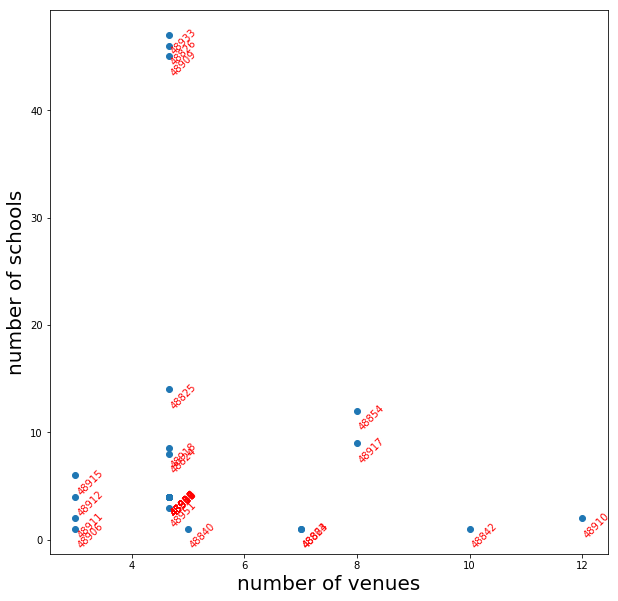

In [587]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x=GL_final['School Name'],y=GL_final['Venue'])
plt.ylabel('number of schools',fontsize=20)
plt.xlabel('number of venues',fontsize=20)
for i, txt in enumerate(GL_final['Zipcode']):
    ax.annotate(txt, (GL_final['School Name'][i],GL_final['Venue'][i]),color='red',rotation=45)

***The above figure suggests the locations with zipcodes 48933, 48826,48909, 48917, 48854, 48825, 48864 ***

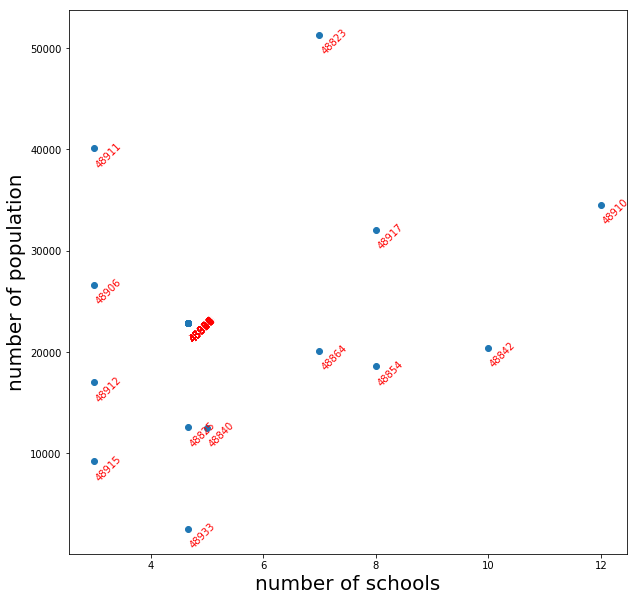

In [491]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x=GL_final['School Name'],y=GL_final['Population'])
plt.ylabel('number of population',fontsize=20)
plt.xlabel('number of schools',fontsize=20)
for i, txt in enumerate(GL_final['Zipcode']):
    ax.annotate(txt, (GL_final['School Name'][i],GL_final['Population'][i]),rotation=45,color='red')

***The above figure suggests the locations with zipcodes 48910, 48917, 48842, 48854, 48864 ***

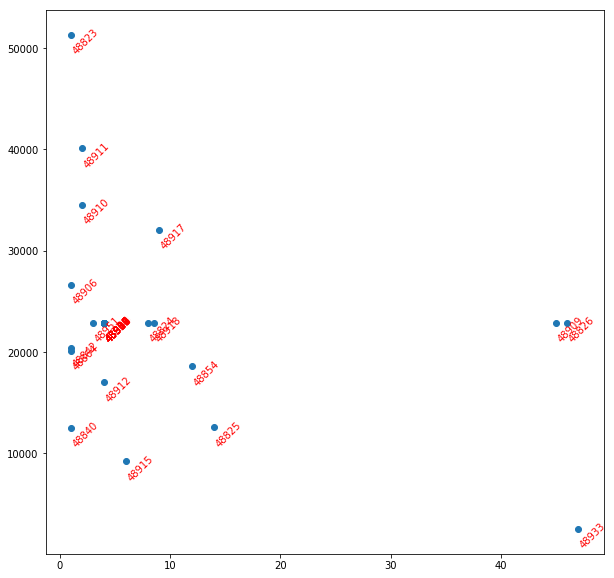

In [493]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x=GL_final['Venue'],y=GL_final['Population'])
for i, txt in enumerate(GL_final['Zipcode']):
    ax.annotate(txt, (GL_final['Venue'][i],GL_final['Population'][i]),rotation=45,color='red')

*** The above figure suggests the locations with zipcodes 48909, 48826, 48825, 48854, 48917.***

[Text(0,0,'48805'),
 Text(0,0,'48823'),
 Text(0,0,'48824'),
 Text(0,0,'48825'),
 Text(0,0,'48826'),
 Text(0,0,'48840'),
 Text(0,0,'48842'),
 Text(0,0,'48854'),
 Text(0,0,'48864'),
 Text(0,0,'48901'),
 Text(0,0,'48906'),
 Text(0,0,'48908'),
 Text(0,0,'48909'),
 Text(0,0,'48910'),
 Text(0,0,'48911'),
 Text(0,0,'48912'),
 Text(0,0,'48913'),
 Text(0,0,'48915'),
 Text(0,0,'48916'),
 Text(0,0,'48917'),
 Text(0,0,'48918'),
 Text(0,0,'48919'),
 Text(0,0,'48922'),
 Text(0,0,'48924'),
 Text(0,0,'48929'),
 Text(0,0,'48930'),
 Text(0,0,'48933'),
 Text(0,0,'48937'),
 Text(0,0,'48951'),
 Text(0,0,'48956'),
 Text(0,0,'48980')]

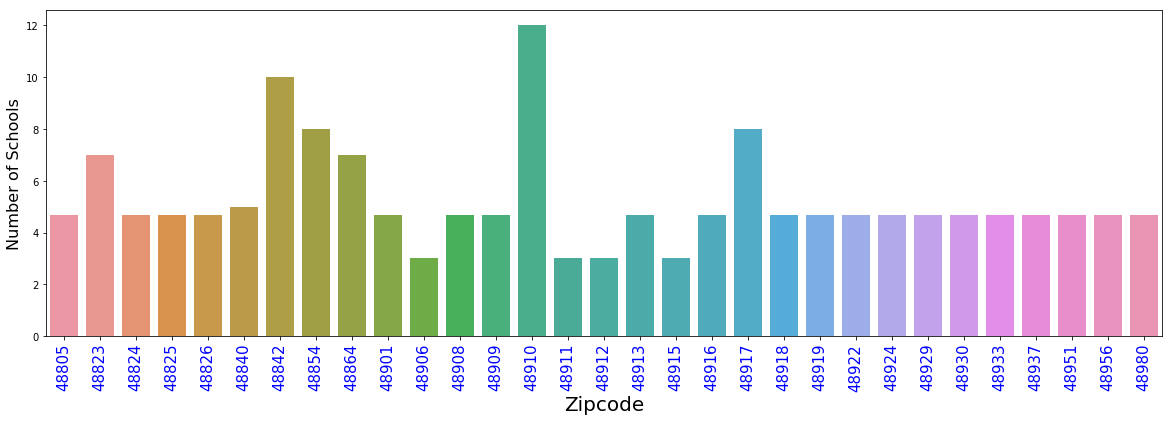

In [495]:
plt.figure(figsize=(20,6))
fig=sns.barplot(x=GL_final['Zipcode'],y=GL_final['School Name'])
plt.xlabel("Zipcode",fontsize=20)
plt.ylabel("Number of Schools",fontsize=16)
fig.set_xticklabels(fig.get_xticklabels(), rotation=90,color='blue',size=15)   

# Discussion

The above analysis indicates that one should choose the location in one of the following neighbourhoods:
48826,48909, 48917, 48854, 48825, 48864. 

In [580]:
best = GL_final[(GL_final['Zipcode']==48864) | (GL_final['Zipcode']==48826) | (GL_final['Zipcode']==48909) | (GL_final['Zipcode']==48917) | (GL_final['Zipcode']==48854) | (GL_final['Zipcode']==48825)]
best

Zipcode  School Name  Venue      Lat      Lon          City    Population
2     48917     8.000000    9.0  42.7238 -84.6400       Lansing  32062.000000
3     48854     8.000000   12.0  42.5820 -84.4517         Mason  18598.000000
5     48864     7.000000    1.0  42.7013 -84.4067        Okemos  20148.000000
7     48826     4.666667   46.0  42.7360 -84.4843  East Lansing  22902.076923
8     48909     4.666667   45.0  42.7311 -84.5526       Lansing  22902.076923
25    48825     4.666667   14.0  42.7270 -84.4809  East Lansing  12596.000000

In [584]:
 # final
for lat, lng, zipcode, population in zip(best['Lat'], best['Lon'], 
                                         best['Zipcode'], best['Population']): 
    labels = 'Zipcode:{}, Population: {}'.format(zipcode,population)
    label = folium.Popup(labels,parse_html=True)
    print(labels)
    folium.CircleMarker(
        [lat, lng],
        radius=10, 
        color='blue',
        popup=label,
        fill=True,
        #fill_color='#3186cc',
        #fill_opacity=0.7,
        parse_html=False).add_to(map_Great_Lansing)  
    
map_Great_Lansing

Zipcode:48917, Population: 32062.0
Zipcode:48854, Population: 18598.0
Zipcode:48864, Population: 20148.0
Zipcode:48826, Population: 22902.076923076922
Zipcode:48909, Population: 22902.076923076922
Zipcode:48825, Population: 12596.0


The above map shows that the neighbourhoods of 48917 and 48854 are far from the downtown. Even though the number of schools and population are large, I would not recommend these two places considering the travel cost.

# Conclusion

** In short, based on all the three factors, I would suggest him to locate the after-school program in 
the neighbourhood with zipcode 48864 or 48826.**



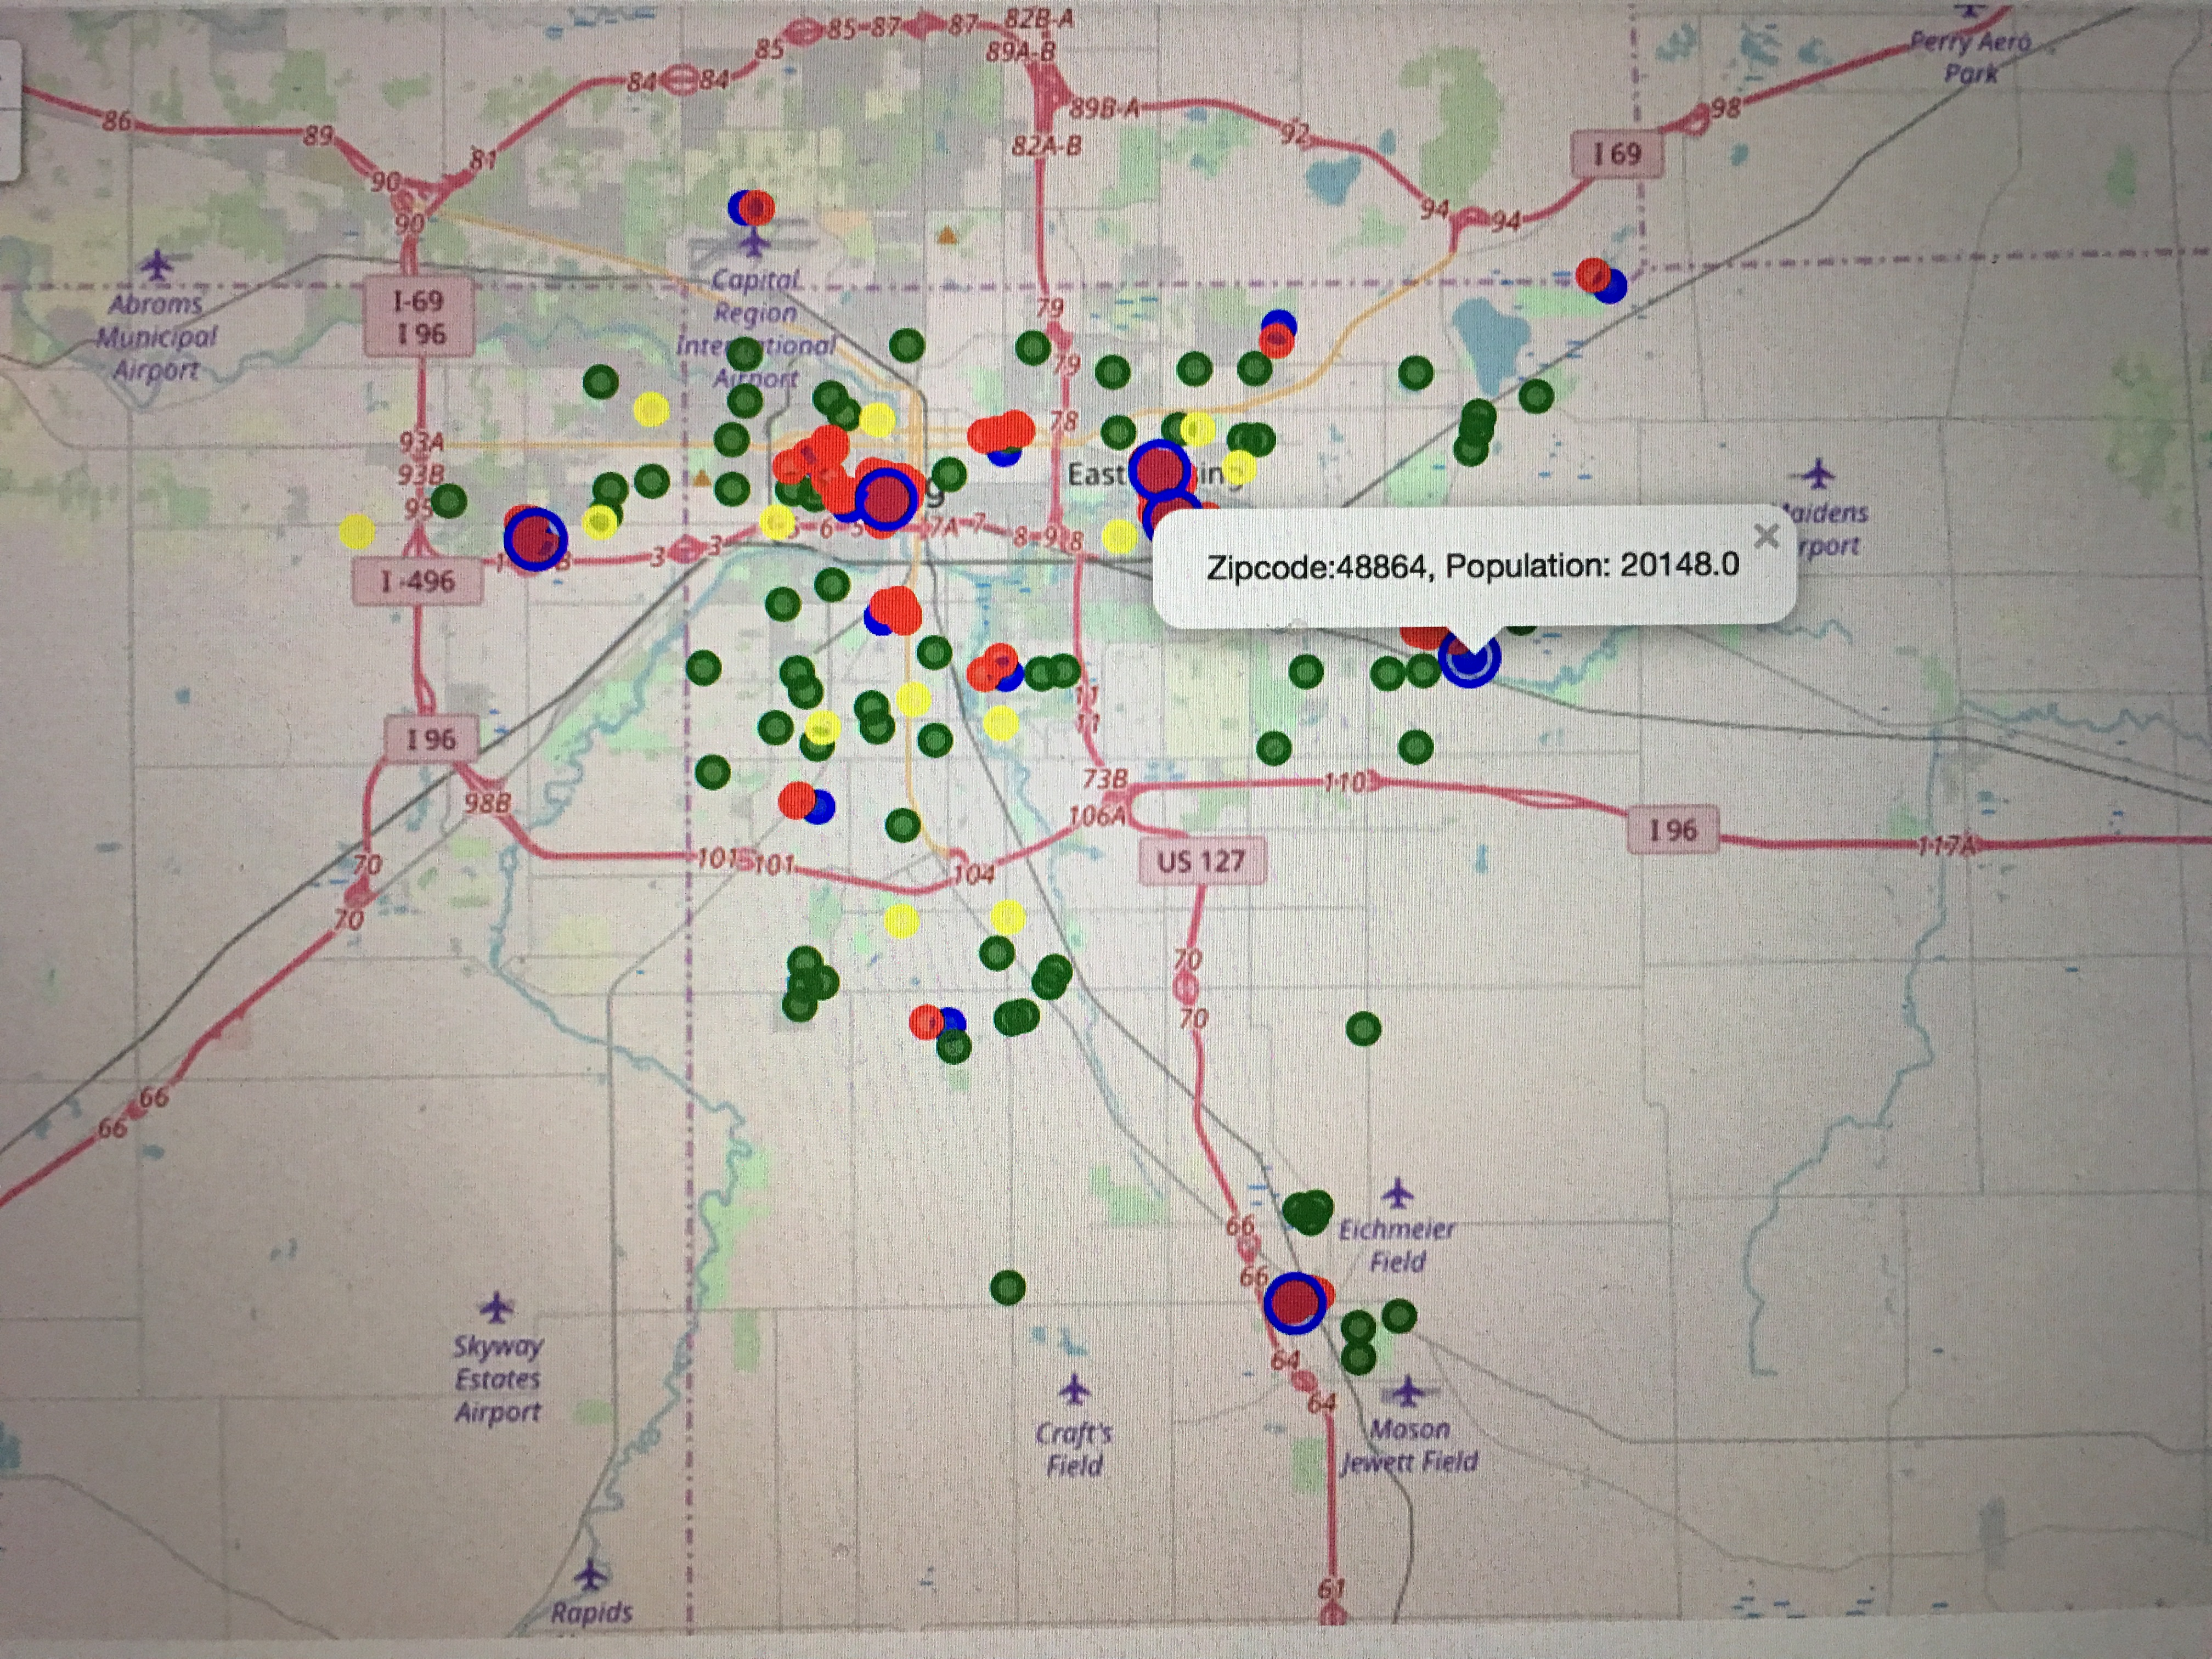

In [586]:
Image('map2.JPG')